In [103]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xgboost as xgb
import catboost as cb
import category_encoders as ce

from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, SplineTransformer, LabelEncoder
from sklearn.decomposition import PCA, KernelPCA

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import (
    cross_validate, GridSearchCV
)

from sklearn.ensemble import RandomForestRegressor

from malbecs.modeling import train as tr
from malbecs.modeling.transformers import QuantileFeatureEncoder, ThresholdFeatureEncoder

seed = 42

final_wine_path = "../../data/final/wine_final.csv"
final_eto_path = "../../data/final/eto_final.csv"
final_meteo_path = "../../data/final/meteo_final.csv"


with open("../../data/final/meteo_features.txt", "r") as f:
    meteo_cols = f.read().split("\n")

with open("../../data/final/eto_features.txt", "r") as f:
    eto_cols = f.read().split("\n")

with open("../../data/final/wine_features.txt", "r") as f:
    wine_cols = f.read().split("\n")
    wine_cols.remove('produccion')


def score_model(X_test, y_test, y_pred, sup_norm=True):
    if sup_norm:
        y_test = X_test['superficie']*y_test
        y_pred = X_test['superficie']*y_pred

    return tr.rmse_score(y_test, y_pred)
    

In [104]:
#load all data
data = tr.load_final_data(
    wine_path=final_wine_path,
    eto_path=final_eto_path,
    meteo_path=final_meteo_path
)

In [105]:
percip_cols = [c for c in eto_cols if "Precip" in c]
snow_cols = [c for c in eto_cols if "Snow" in c]
temp_day_cols = [c for c in eto_cols if "TemperatureLocalDay" in c]
temp_cols = [c for c in eto_cols if "TemperatureLocalAfter" in c or "TemperatureLocalOvern" in c]
evotrans_cols = [c for c in eto_cols if "Evapotranspiration" in c]
feelslike_cols = [c for c in eto_cols if "FeelsLikeLoca" in c]
irrad_cols = [c for c in eto_cols if "Irradiance" in c]
gust_cols = [c for c in eto_cols if "Gust" in c]
wind_cols = [c for c in eto_cols if "Wind" in c]
dewpoint_cols = [c for c in eto_cols if "Dewpoint" in c]
mslp_cols = [c for c in eto_cols if "MSLP" in c]
humid_cols = [c for c in eto_cols if "Humidity" in c]
uvindex_cols = [c for c in eto_cols if "UVIndex" in c]
visib_cols = [c for c in eto_cols if "Visibility" in c]

In [106]:
# meteo_cols
# snow_cols

# wine_cols
# data.head()

# pd.read_csv('../../data/final/wine_final.csv').columns

In [152]:
# data prep

data_train = tr.filter_camp(data.copy(), min_camp=14, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca', 
    'id_zona',
    'id_estacion', 
    'variedad',
    "modo", 
    "tipo",
    "color", 
    "prod_shift1_gt_shift2"
]

num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')
X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)


train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)

# train_idxs, test_idxs = tr.CampKFold.get_train_test(
#     X_train['campaña'], from_camp=19, to_camp=20
# )
# cv_train = tr.CampKFold(train_idxs, test_idxs)

In [153]:
# tra = ThresholdFeatureEncoder(col="altitud").fit(X_train[['altitud']], y_train)
# tra.transform(data[['altitud']]).value_counts(dropna=False)
# tra.value_counts(dropna=False)
# QuantileFeatureEncoder(col="id_finca").fit_transform(X_train[['id_finca']], y_train).value_counts()
# 
# QuantileFeatureEncoder(col="id_finca").fit(
#     X_train[['id_finca']], y_train).category_encodings_


In [154]:
# X[model_cat_cols+model_num_cols]
# pd.DataFrame(
    # m[:-1].fit_transform(X,y),
    # columns=m[:-1].get_feature_names_out()
# )

In [180]:

wine_num_cols = [c for c in wine_cols if c not in cat_cols]

model_num_cols = [
    "campaña",
    'superficie',
    # 'prod_shift1',
    # 'prod_shift2',
    
    'prod_shift_max',
    # 'prod_shift_change',
    'prod_shift_avg',
    'prod_est_mean_change'
]

model_cat_cols = [
    'id_finca',
    'id_zona',
    "id_estacion",
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2"
]

m = make_pipeline( 
    make_column_transformer(
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), model_cat_cols),
        # (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['variedad']),

        # (FunctionTransformer(lambda x: x), model_cat_cols),
        
        # (make_pipeline(QuantileFeatureEncoder(col="id_finca"),MinMaxScaler()), ['id_finca']),
        # (make_pipeline(QuantileFeatureEncoder(col="id_zona"),MinMaxScaler()), ['id_zona']),

        (QuantileFeatureEncoder(col="id_zona"), ['id_zona']),
        (QuantileFeatureEncoder(col="id_finca"), ['id_finca']),
        
        (ThresholdFeatureEncoder(col='altitud'), ['altitud']),
        (ThresholdFeatureEncoder(col='variedad'), ['variedad']),

        (KBinsDiscretizer(n_bins=5), ['altitud']),

        (MinMaxScaler(), model_num_cols),
        # (StandardScaler(), percip_cols),
        # (StandardScaler(), [c for c in percip_cols if "Sum" in c ]),
        # (StandardScaler(), temp_cols),
        # (StandardScaler(), [c for c in snow_cols if "Sum" in c]),
        # (StandardScaler(), temp_day_cols),
        # (StandardScaler(), gust_cols),
        remainder='drop'
    ),
    RandomForestRegressor(
        random_state=seed,
        n_estimators=200,
        # n_estimators=400,
        min_samples_leaf=3,
        n_jobs=-1,
        max_features='sqrt',
        # max_features=0.5
        # max_depth=12,
    )
)
# {'randomforestregressor__max_depth': 12, 'randomforestregressor__max_features': 0.5,
    # 'randomforestregressor__n_estimators': 800}

res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)

print("test: ",res['test_score'])
print("train: ",res['train_score'])

# train-test score
y_pred = m.fit(X_train, y_train).predict(X_test)
score_model(X_test, y_test, y_pred, sup_norm=False)

#   [-4935.19287851 -6743.4876379  -5446.52899653]

test:  [-5207.75457533 -6984.55099393 -5439.95479037]
train:  [-4605.07130636 -4418.20168684 -4449.55957715]


5439.954790371621

In [143]:
# param_grid = {
    # 'xgbregressor__min_child_weight': [1, 5, 10],
    # 'xgbregressor__gamma': [0.5, 1, 1.5, 2, 5],
    # 'xgbregressor__subsample': [0.6, 0.8],
    # 'xgbregressor__colsample_bytree': [0.5,0.7,0.8],
    # 'xgbregressor__max_depth': [2, 3, 4],
    # 'xgbregressor__n_estimators':[200,400,800],
    # 'xgbregressor__learning_rate':[0.005,0.01,0.05]
# }

# param_grid = {
#     'randomforestregressor__max_features': ['sqrt','log2',0.5, 0.7, 0.8],
#     'randomforestregressor__max_depth': [3, 4, 5, 6, 8, 12],
#     'randomforestregressor__n_estimators': [200, 400, 500, 800],
# }

# gsm = GridSearchCV(
#     m,
#     param_grid=param_grid,
#     cv=cv,
#     verbose=1,
#     scoring=tr.rmse_scorer
# )

# gsm.fit(X,y)

# print(gsm.best_params_)
# print(gsm.best_score_)

Fitting 1 folds for each of 120 candidates, totalling 120 fits
{'randomforestregressor__max_depth': 12, 'randomforestregressor__max_features': 0.5, 'randomforestregressor__n_estimators': 800}
-5458.573206460847


In [145]:
# m = gsm.best_estimator_
# y_pred = m.fit(X_train, y_train).predict(X_test)
# score_model(X_test, y_test, y_pred, sup_norm=False)

5458.573206460847

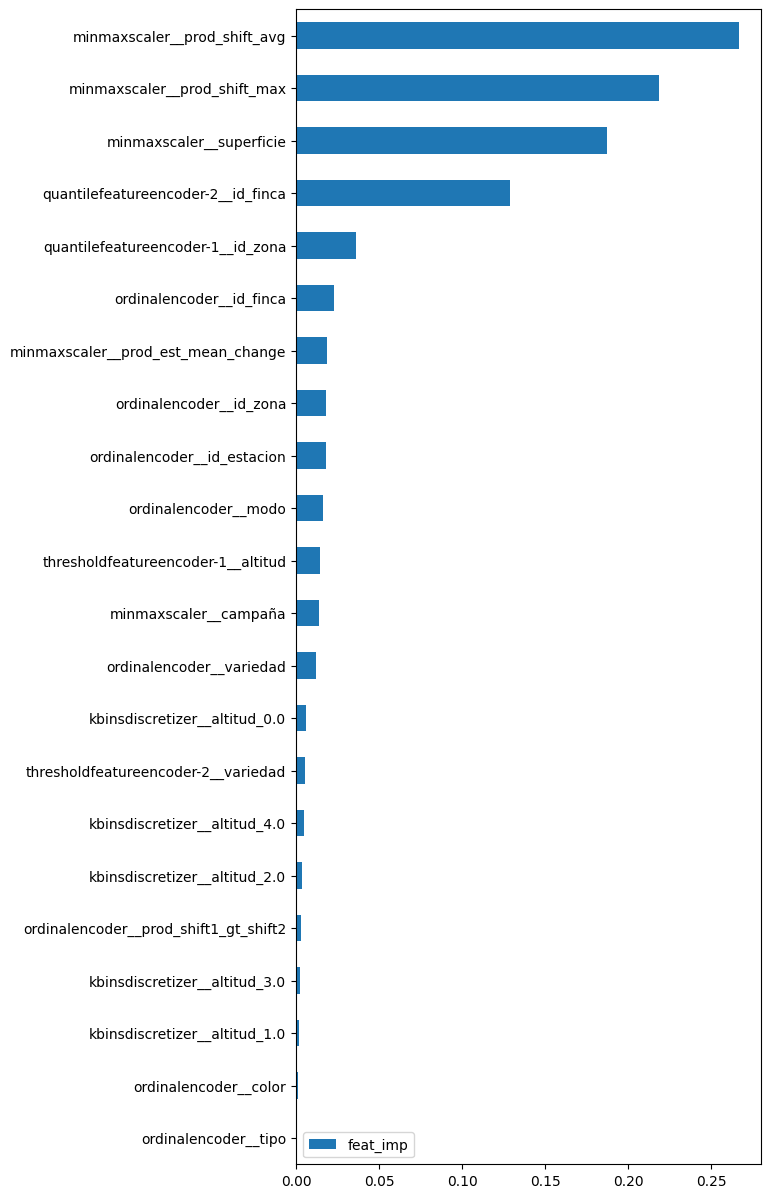

In [175]:
def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6, 15))


show_feat_imps(
    m[-1].feature_importances_,
    m[:-1].get_feature_names_out(),
)

# show_feat_imps(
#     gsm.best_estimator_[-1].feature_importances_,
#     gsm.best_estimator_[:-1].get_feature_names_out(),
# )


In [159]:
# import shap


In [168]:
preds_denis = pd.read_csv('../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_1.txt', sep="|", header=None)

y_pred_final = m.fit(X, y).predict(X_final)


In [169]:
preds_final = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final['produccion'] = y_pred_final
preds_final = preds_final.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

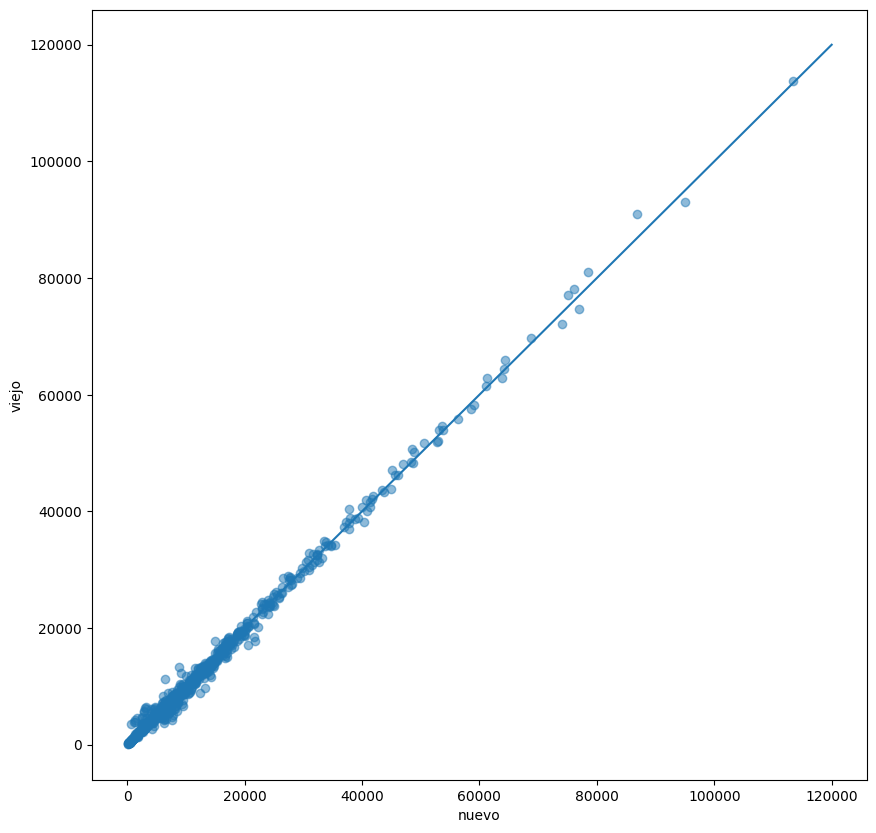

In [170]:
plt.figure(figsize=(10, 10))
plt.scatter(x=preds_final.iloc[:,-1],
            y=preds_denis.iloc[:, -1], alpha=0.5)
plt.plot([0, 120000], [0, 120000])
plt.xlabel('nuevo')
plt.ylabel('viejo')
# plt.xlim(0,40000)
# plt.ylim(0,40000)
plt.show()


In [185]:
preds_denis = pd.read_csv(
    "../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_1.txt", sep="|", header=None)

preds_nuevas = pd.read_csv(
    "../../data/final/UH2023_Universidad Complutense de Madrid(UCM)_Malbecs.txt", sep="|", header=None)


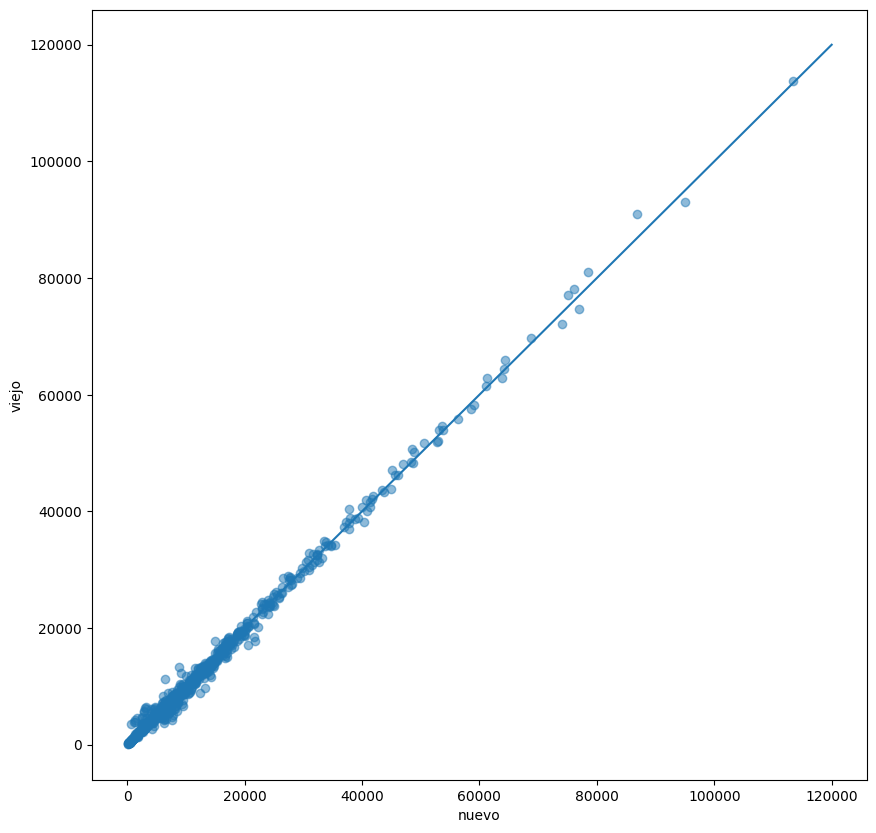

In [186]:
plt.figure(figsize=(10, 10))
plt.scatter(x=preds_nuevas.iloc[:, -1],
            y=preds_denis.iloc[:, -1], alpha=0.5)
plt.plot([0, 120000], [0, 120000])
plt.xlabel('nuevo')
plt.ylabel('viejo')
# plt.xlim(0,40000)
# plt.ylim(0,40000)
plt.show()
